In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 12 - Psychophysical functions
  
A psychophysical function, showing the a sigmoid or S-shaped relationship between stimulus intensity and choice behavior. Important theoretical measures known as the point of subjective equality (PSE) and just noticeable difference (JND) are highlighted.

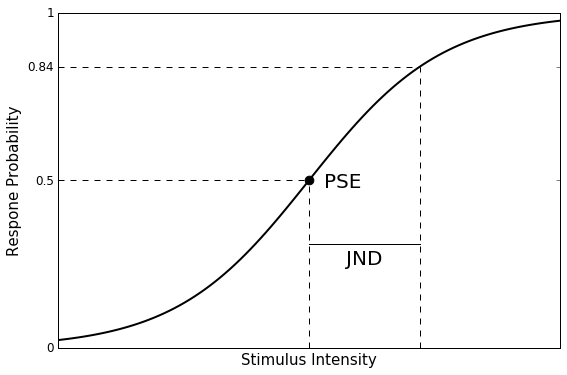

In [2]:
def logit(x):
    return 1/(1+np.exp(-x))
def invlogit(x):
    return np.log(x/(1-x))

x = np.linspace(-3.75, 3.75, 100)
fig, ax = plt.subplots(figsize=(9, 6))
x1 = invlogit(.5)
x2 = invlogit(.84)

plt.plot(x, logit(x), 'k', linewidth=2)
plt.plot([x1,x1],[0,.5], color='k', linestyle='--', linewidth=1)
plt.plot([-3.75,x1],[.5,.5], color='k', linestyle='--', linewidth=1)
plt.plot([x2,x2],[0,.84], color='k', linestyle='--', linewidth=1)
plt.plot([-3.75,x2],[.84,.84], color='k', linestyle='--', linewidth=1)

plt.scatter(x1,.5, c='k', s=75)
plt.text(x1+.5, .5-.02, "PSE", horizontalalignment='center', fontsize=20)
plt.plot([x1,x2],[.5/2+.06,.5/2+.06], color='k', linewidth=1)
plt.text((x1+x2)/2, .5/2, "JND", horizontalalignment='center', fontsize=20)

ax.set_xticks(())
ax.set_yticks((0, .5, .84, 1))
ax.set_yticklabels(('0','0.5', '0.84','1'),fontsize=12)
plt.xlim(-3.75,3.75)
plt.ylim(0,1)
plt.xlabel('Stimulus Intensity',fontsize=15)
plt.ylabel('Respone Probability',fontsize=15)
plt.show()

Data for all 8 subjects, showing the proportion of “long” responses as a function of test interval duration.

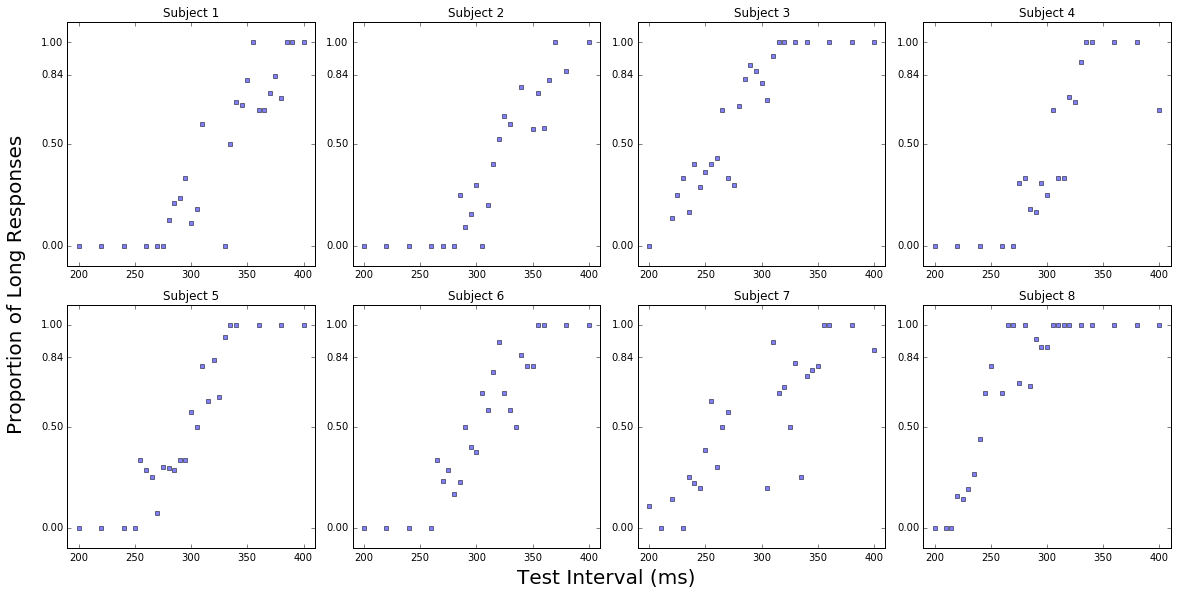

In [3]:
x = pd.read_csv("./data/data_x.txt",sep='\t',header=None)
n = pd.read_csv("./data/data_n.txt",sep='\t',header=None)
r = pd.read_csv("./data/data_r.txt",sep='\t',header=None)
rprop = pd.read_csv("./data/data_rprop.txt",sep='\t',header=None)

xmean = np.array([318.888, 311.0417, 284.4444, 301.5909, 
           296.2000, 305.7692, 294.6429, 280.3571])
nstim = np.array([27, 24, 27, 22, 25, 26, 28, 28])
nsubjs = 8

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical',fontsize=20)
gs = gridspec.GridSpec(2,4)

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip,:])
    yp = np.array(rprop.iloc[ip,:])
    ax.scatter(xp,yp,marker='s',alpha=.5)
    plt.axis([190,410,-.1,1.1])
    plt.yticks((0,.5,.84,1))
    plt.title('Subject'+' '+str(ip+1))

plt.tight_layout()
plt.show()

The psychometric function here is a logistic function with parameters $\alpha_i$ and $\beta_i$:  

$$ \theta_{ij} = \frac{1}{1+\text{exp}\{-[\alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})]\}}$$  
$$\text{or}$$   
$$ \text{logit}(\theta_{ij}) = \alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})$$

## 12.1 Psychophysical functions


$$ r_{ij} \sim \text{Binomial}(\theta_{ij},n_{ij})$$
$$ \text{logit}(\theta_{ij}) = \alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha},\sigma_{\alpha})$$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta},\sigma_{\beta})$$
$$ \mu_{\alpha} \sim \text{Gaussian}(0,0.001)$$
$$ \mu_{\beta} \sim \text{Gaussian}(0,0.001)$$
$$ \sigma_{\alpha} \sim \text{Uniform}(0,1000)$$
$$ \sigma_{\beta} \sim \text{Uniform}(0,1000)$$

In [4]:
xij_tmp=x.values
nij_tmp=n.values
rij_tmp=r.values
tmp,nstim2=np.shape(xij_tmp)

xmeanvect=np.repeat(xmean,nstim2)
sbjidx=np.repeat(np.arange(nsubjs),nstim2)

# remove nans
validmask=np.isnan(xij_tmp.flatten())==False
xij2=xij_tmp.flatten()
nij2=nij_tmp.flatten()
rij2=rij_tmp.flatten()

xij = xij2[validmask]
nij = nij2[validmask]
rij = rij2[validmask]
xvect = xmeanvect[validmask]
sbjid = sbjidx[validmask]

Applied interval-transform to sigma_a and added transformed sigma_a_interval to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 4.1 sec

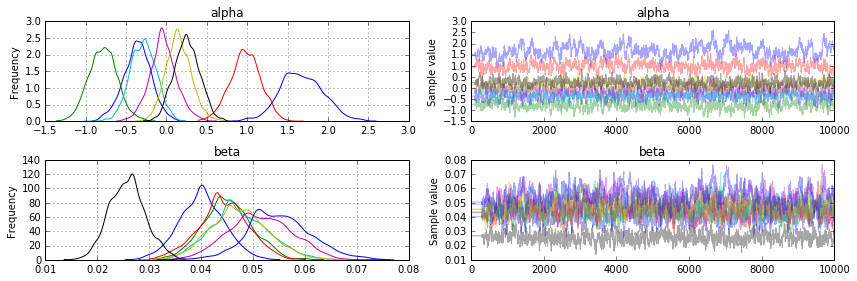

In [5]:
with pm.Model() as model1:
    sigma_a = pm.Uniform("sigma_a",lower=0,upper=1000)
    sigma_b = pm.Uniform("sigma_b",lower=0,upper=1000)
    mu_a = pm.Normal("mu_a",mu=0,tau=.001)
    mu_b = pm.Normal("mu_b",mu=0,tau=.001)
    alpha = pm.Normal("alpha",mu=mu_a,sd=sigma_a,shape=nsubjs)
    beta = pm.Normal("beta",mu=mu_b,sd=sigma_b,shape=nsubjs)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    def tlogit(x):
        return 1/(1+T.exp(-x))
    thetaij=pm.Deterministic("thetaij",tlogit(linerpredi))
    
    rij2 = pm.Binomial("rij2",p=thetaij,n=nij,observed=rij)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace1 = pm.sample(1e4, start=start,step = pm.Metropolis(), model=model1)
    
pm.traceplot(trace1,varnames=['alpha','beta'])
plt.show()

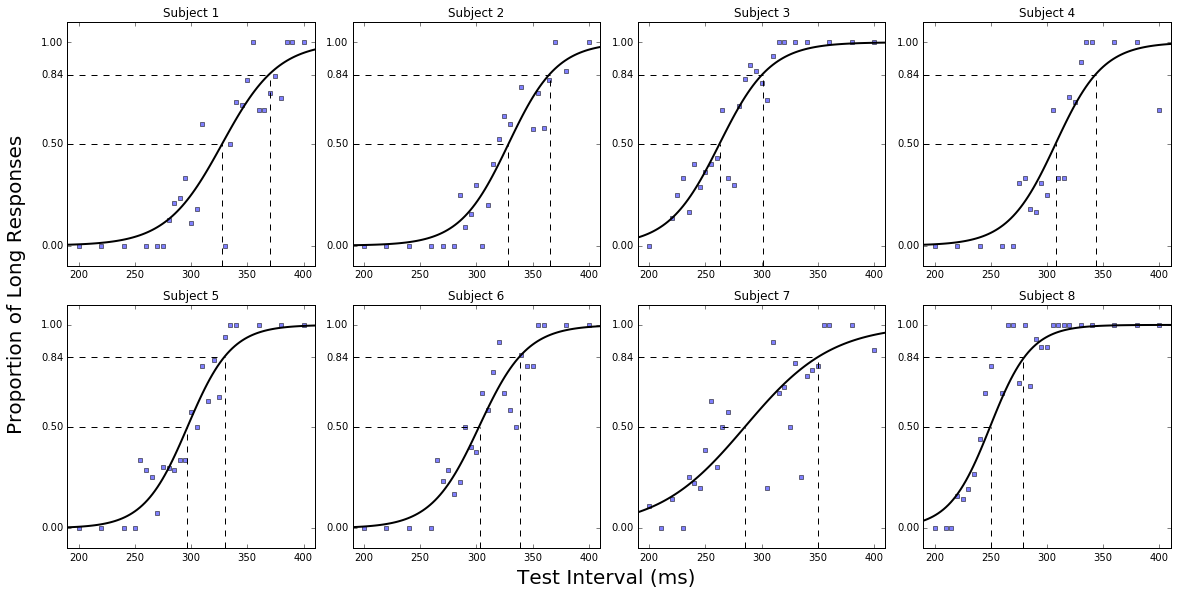

In [6]:
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical',fontsize=20)
gs = gridspec.GridSpec(2,4)

burnin=5000
# get MAP estimate
tmp = pm.df_summary(trace1[burnin:],varnames=['alpha','beta'])
alphaMAP = tmp['mean'][np.arange(nsubjs)]
betaMAP = tmp['mean'][np.arange(nsubjs)+nsubjs]

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip,:])
    yp = np.array(rprop.iloc[ip,:])
    ax.scatter(xp,yp,marker='s',alpha=.5)
    
    xl = np.linspace(190, 410, 100)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl,.5)]
    x2 = xl[find_nearest(yl,.84)]

    plt.plot(xl, yl, 'k', linewidth=2)
    plt.plot([x1,x1],[-.1,.5], color='k', linestyle='--', linewidth=1)
    plt.plot([190,x1],[.5,.5], color='k', linestyle='--', linewidth=1)
    plt.plot([x2,x2],[-.1,.84], color='k', linestyle='--', linewidth=1)
    plt.plot([190,x2],[.84,.84], color='k', linestyle='--', linewidth=1)

    plt.axis([190,410,-.1,1.1])
    plt.yticks((0,.5,.84,1))
    plt.title('Subject'+' '+str(ip+1))
    
plt.tight_layout()
plt.show()

In [ ]:
# Posterior sample
from collections import defaultdict
alphadist=model1.alpha
betadist=model1.beta

ppcsamples=500
ppcsize=100
ppc = defaultdict(list)
for idx in np.random.randint(burnin, 1e4, ppcsamples):
    param = trace1[idx]
    ppc['alpha'].append(alphadist.distribution.random(point=param,size=ppcsize))
    ppc['beta'].append(betadist.distribution.random(point=param,size=ppcsize))
    
# np.asarray(ppc['alpha']).shape
alphaPPC=np.asarray(ppc['alpha']).mean(axis=1)
betaPPC=np.asarray(ppc['beta']).mean(axis=1)

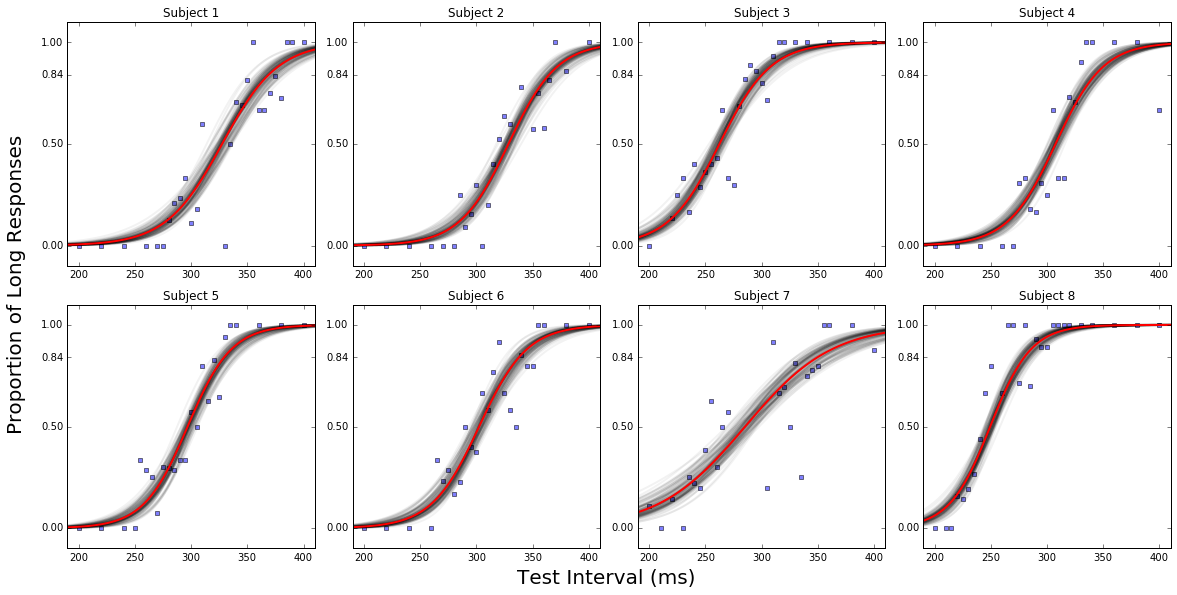

In [7]:
# PLOT FOR EXERCISE 12.1.2 
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical',fontsize=20)
gs = gridspec.GridSpec(2,4)

ppcsamples=100

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip,:])
    yp = np.array(rprop.iloc[ip,:])
    ax.scatter(xp,yp,marker='s',alpha=.5)
    
    xl = np.linspace(190, 410, 100)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))

    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 1e4, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        plt.plot(xl, yl2, 'k', linewidth=2,alpha=.05)
    
    plt.plot(xl, yl, 'r', linewidth=2)
    
    plt.axis([190,410,-.1,1.1])
    plt.yticks((0,.5,.84,1))
    plt.title('Subject'+' '+str(ip+1))
    
    
plt.tight_layout()
plt.show()

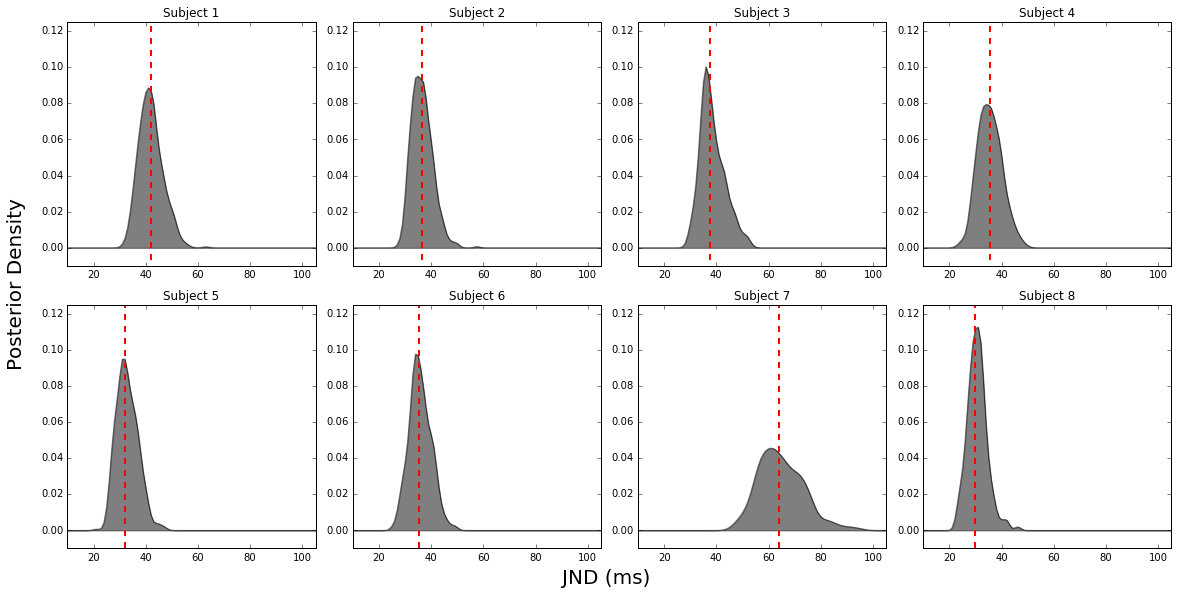

In [8]:
# PLOT FOR EXERCISE 12.1.4 
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'JND (ms)', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Posterior Density', va='center', rotation='vertical',fontsize=20)
gs = gridspec.GridSpec(2,4)

ppcsamples=500

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    
    xl = np.linspace(190, 410, 200)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl,.5)]
    x2 = xl[find_nearest(yl,.84)]
    jnd1 = x2-x1
    
    # Posterior sample
    jndps=[]
    for ips in np.random.randint(burnin, 1e4, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2,.5)]
        x2 = xl[find_nearest(yl2,.84)]
        jndps.append(x2-x1)
        
    pdfpc = gaussian_kde(jndps)
    x2=np.linspace(10,109,100)
    plt.plot(x2,pdfpc(x2),'k',alpha=.5) 
    plt.fill_between(x2,pdfpc(x2),0,alpha=.5,color='k')
    plt.plot([jnd1,jnd1], [-.1,.125], 'r--', linewidth=2)
    
    plt.axis([10,105,-.01,.125])
    plt.title('Subject'+' '+str(ip+1))
    
    
plt.tight_layout()
plt.show()

## 12.2 Psychophysical functions under contamination

Latent-mixture model approach  
$$ r_{ij} \sim \text{Binomial}(\theta_{ij},n_{ij})$$

$$   \theta_{ij} \sim
\begin{cases}
\frac{1}{1+\text{exp}\{-[\alpha_{i}+\beta_{i}(x_{ij}-\bar x_{i})]\}}  & \text{if $z_{ij} = 0$} \\
\pi_{ij}  & \text{if $z_{ij} = 1$}
\end{cases}  $$

$$ \Phi^{-1}(\phi_{i}) \sim \text{Gaussian}(\mu_{\phi},\sigma_{\phi})$$
$$ z_{ij} \sim \text{Bernoulli}(\phi_{i})$$
$$ \pi_{ij} \sim \text{Uniform}(0,1)$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha},\sigma_{\alpha})$$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta},\sigma_{\beta})$$
$$ \mu_{\alpha},\mu_{\beta},\mu_{\phi} \sim \text{Gaussian}(0,0.001)$$
$$ \sigma_{\alpha},\sigma_{\beta} \sim \text{Uniform}(0,1000)$$
$$ \sigma_{\phi} \sim \text{Uniform}(0,3)$$

NOTICE: In the model following I set the prior of $\sigma$ to $ \sigma_{\alpha},\sigma_{\beta},\sigma_{\phi} \sim \text{Uniform}(0,3)$. Otherwise the model does not converge to the desired parameters.

Applied interval-transform to sigma_a and added transformed sigma_a_interval to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval to model.
Applied interval-transform to sigma_p and added transformed sigma_p_interval to model.
Applied interval-transform to pi_ij0 and added transformed pi_ij0_interval to model.
Applied interval-transform to pi_ij1 and added transformed pi_ij1_interval to model.
Applied interval-transform to pi_ij2 and added transformed pi_ij2_interval to model.
Applied interval-transform to pi_ij3 and added transformed pi_ij3_interval to model.
Applied interval-transform to pi_ij4 and added transformed pi_ij4_interval to model.
Applied interval-transform to pi_ij5 and added transformed pi_ij5_interval to model.
Applied interval-transform to pi_ij6 and added transformed pi_ij6_interval to model.
Applied interval-transform to pi_ij7 and added transformed pi_ij7_interval to model.
Assigned NUTS to sigma_a_interval
Assigned NUTS to sigma_b_

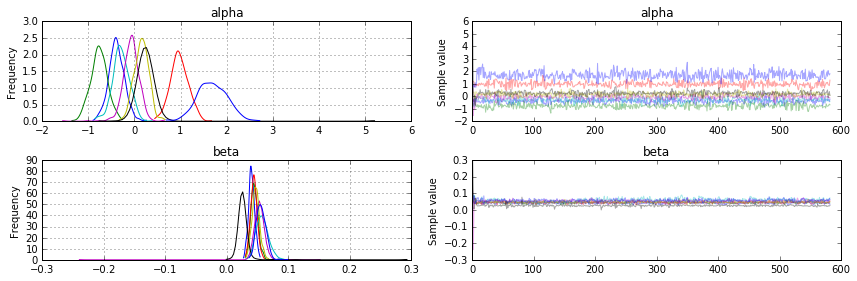

In [10]:
#
probitphi=dict()
zij=dict()
phii=dict()
pi_ij=dict()
linerpredi=dict()
thetaij=dict()
rij2=dict()
with pm.Model() as model2a:
    # psychophysical function
    sigma_a = pm.Uniform("sigma_a",lower=0,upper=3)# change here so that the sampling is faster
    sigma_b = pm.Uniform("sigma_b",lower=0,upper=3)
    mu_a = pm.Normal("mu_a",mu=0,tau=.001)
    mu_b = pm.Normal("mu_b",mu=0,tau=.001)
    alpha = pm.Normal("alpha",mu=mu_a,sd=sigma_a,shape=nsubjs)
    beta = pm.Normal("beta",mu=mu_b,sd=sigma_b,shape=nsubjs)
    
    def Phi(x):
        # probit transform 
        return (1.0 + T.erf(x / np.sqrt(2.0))) / 2.0
    def tlogit(x):
        return 1/(1+T.exp(-x))
    
    # latent model for contamination
    sigma_p = pm.Uniform("sigma_p",lower=0,upper=3)
    mu_p = pm.Normal("mu_p",mu=0,tau=.001)
    probitphi=pm.Normal("probitphi",mu=mu_p,sd=sigma_p,shape=nsubjs)
    phii=pm.Deterministic("phii",Phi(probitphi))
        
    for i in np.arange(nsubjs):
        zij[i]=pm.Bernoulli("zij_%i"%i,p=phii[i],shape=nstim[i])
        pi_ij[i]=pm.Uniform("pi_ij%i"%i,lower=0,upper=1,shape=nstim[i])
        linerpredi[i]=alpha[i] + beta[i]*(xij_tmp[i,0:nstim[i]]-xmean[i])
        
        thetaij[i]=pm.Deterministic("thetaij%i"%i,tlogit(linerpredi[i])*T.eq(zij[i],0)+pi_ij[i]*T.eq(zij[i],1))
        
        rij2[i]=pm.Binomial("rij2%i"%i,p=thetaij[i],n=nij_tmp[i,0:nstim[i]],observed=rij_tmp[i,0:nstim[i]])
        
#     start = pm.find_MAP()
#     step = pm.NUTS(scaling=start)
    trace2a = pm.sample(3e3, model=model2a)
    
pm.traceplot(trace2a[50:],varnames=['alpha','beta'])
plt.show()

Applied interval-transform to sigma_a and added transformed sigma_a_interval to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval to model.
Applied interval-transform to sigma_p and added transformed sigma_p_interval to model.
Applied interval-transform to pi_ij and added transformed pi_ij_interval to model.
Assigned NUTS to sigma_a_interval
Assigned NUTS to sigma_b_interval
Assigned NUTS to mu_a
Assigned NUTS to mu_b
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_p_interval
Assigned NUTS to mu_p
Assigned NUTS to probitphi
Assigned BinaryGibbsMetropolis to zij
Assigned NUTS to pi_ij_interval
 [-----------------100%-----------------] 3001 of 3000 complete in 4870.2 sec

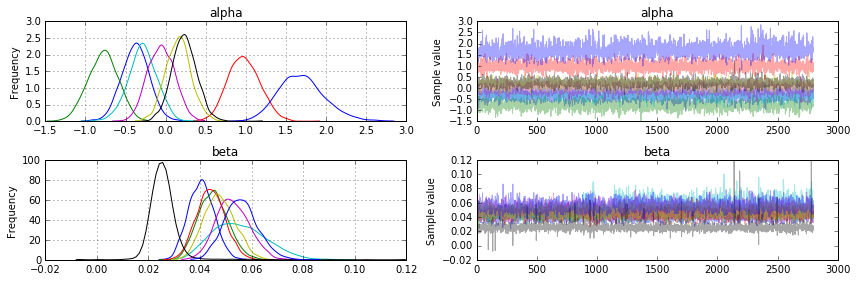

In [14]:
import theano
tshare = theano.shared(np.ones(nstim2))

masktmp = np.zeros(validmask.size)
masktmp[validmask] = 1
validmask2=theano.shared(masktmp)

with pm.Model() as model2b:
    sigma_a = pm.Uniform("sigma_a",lower=0,upper=3)# change here so that the sampling is faster
    sigma_b = pm.Uniform("sigma_b",lower=0,upper=3)# 
    mu_a = pm.Normal("mu_a",mu=0,tau=.001)
    mu_b = pm.Normal("mu_b",mu=0,tau=.001)
    alpha = pm.Normal("alpha",mu=mu_a,sd=sigma_a,shape=nsubjs)
    beta = pm.Normal("beta",mu=mu_b,sd=sigma_b,shape=nsubjs)
    
    # latent model for contamination
    sigma_p = pm.Uniform("sigma_p",lower=0,upper=3)
    mu_p = pm.Normal("mu_p",mu=0,tau=.001)
    def Phi(x):
        # probit transform 
        return (1.0 + T.erf(x / np.sqrt(2.0))) / 2.0
    probitphi=pm.Normal("probitphi",mu=mu_p,sd=sigma_p,shape=nsubjs,testval=np.ones(nsubjs))
    phii=pm.Deterministic("phii",Phi(probitphi))
    
    zij=pm.Bernoulli("zij",p=T.outer(phii,tshare),shape=(nsubjs,nstim2))
    pi_ij=pm.Uniform("pi_ij",lower=0,upper=1,shape=(nsubjs,nstim2))
    
    zijv1 = T.flatten(zij)
    zijv = zijv1[(validmask2>0).nonzero()]
    pi_ijv1 = T.flatten(pi_ij)
    pi_ijv = pi_ijv1[(validmask2>0).nonzero()]
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    def tlogit(x):
        return 1/(1+T.exp(-x))
    thetaij=pm.Deterministic("thetaij",tlogit(linerpredi)*T.eq(zijv,0)+pi_ijv*T.eq(zijv,1))
    
#     print(probitphi.tag.test_value)
#     print(zijv.tag.test_value)
#     print(thetaij.tag.test_value)
    
    rij2 = pm.Binomial("rij",p=thetaij,n=nij,observed=rij)
#     start = pm.find_MAP()
#     step = pm.NUTS(scaling=start)
    trace2b = pm.sample(3e3, model=model2b)
    
pm.traceplot(trace2b[200:],varnames=['alpha','beta'])
plt.show()

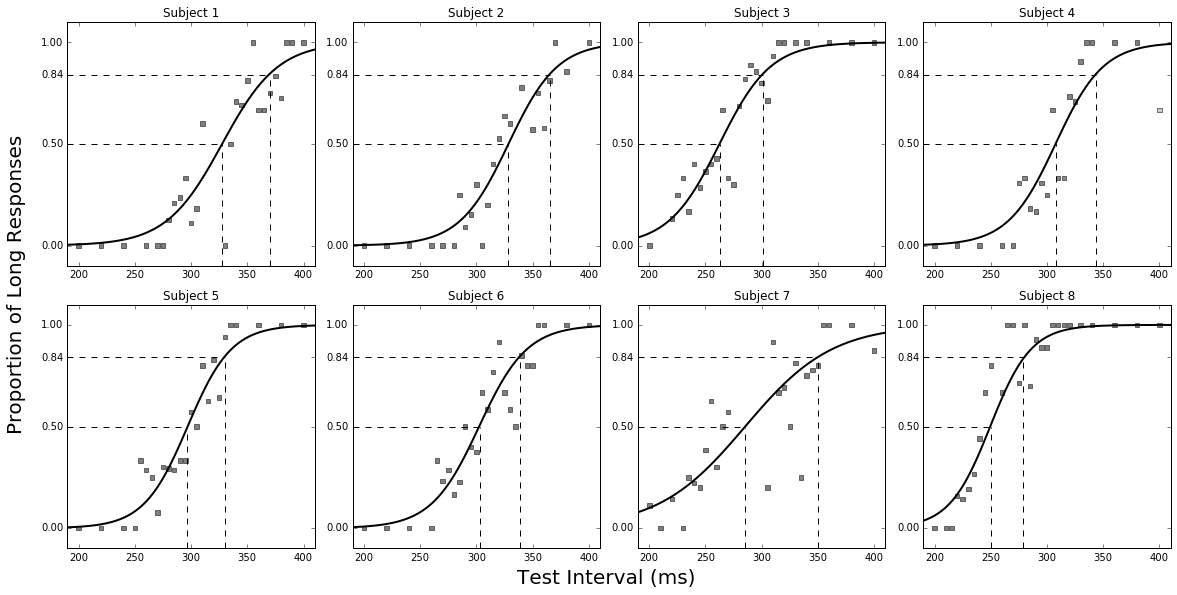

In [15]:
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical',fontsize=20)
gs = gridspec.GridSpec(2,4)

trace2=trace2b
burnin=50
# get MAP estimate
tmp = pm.df_summary(trace2[burnin:],varnames=['alpha','beta'])
tmp2 = pm.df_summary(trace2[burnin:],varnames=['zij'])

alphaMAP2 = tmp['mean'][np.arange(nsubjs)]
betaMAP2 = tmp['mean'][np.arange(nsubjs)+nsubjs]

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    xp = np.array(x.iloc[ip,:])
    yp = np.array(rprop.iloc[ip,:])
    v1 = np.asarray(tmp2['mean'][sbjidx==ip])
    ax.scatter(xp,yp,marker='s',color=np.repeat(v1,3).reshape(-1,3),alpha=.5,edgecolor='k')
    
    xl = np.linspace(190, 410, 100)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl,.5)]
    x2 = xl[find_nearest(yl,.84)]

    plt.plot(xl, yl, 'k', linewidth=2)
    plt.plot([x1,x1],[-.1,.5], color='k', linestyle='--', linewidth=1)
    plt.plot([190,x1],[.5,.5], color='k', linestyle='--', linewidth=1)
    plt.plot([x2,x2],[-.1,.84], color='k', linestyle='--', linewidth=1)
    plt.plot([190,x2],[.84,.84], color='k', linestyle='--', linewidth=1)

    plt.axis([190,410,-.1,1.1])
    plt.yticks((0,.5,.84,1))
    plt.title('Subject'+' '+str(ip+1))
    
plt.tight_layout()
plt.show()

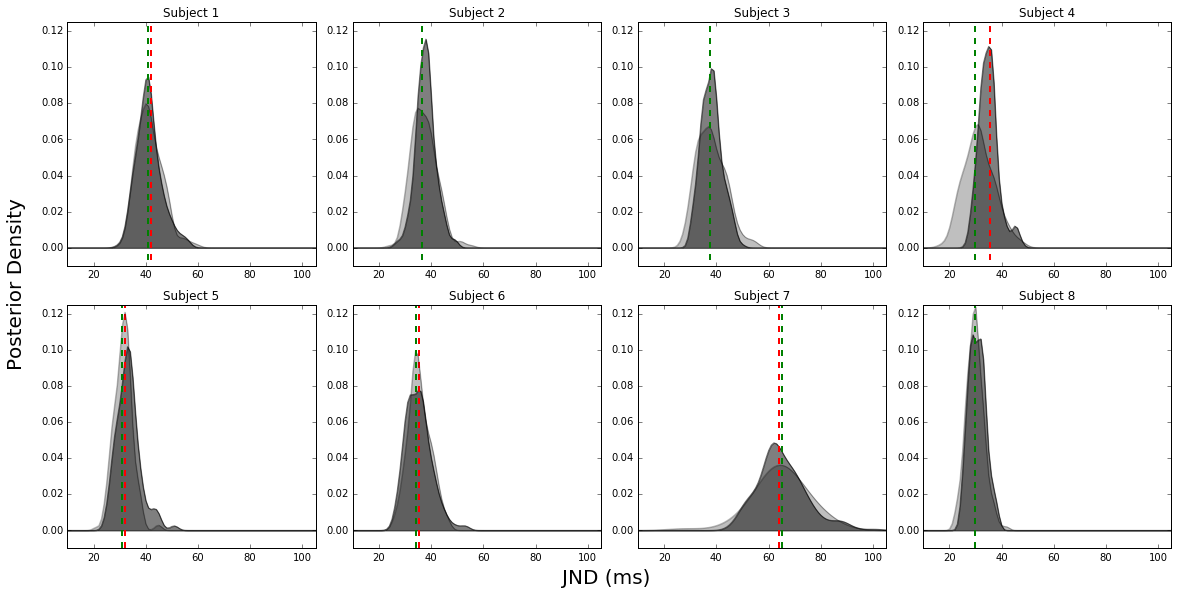

In [16]:
# PLOT FOR EXERCISE 12.1.4 
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'JND (ms)', ha='center',fontsize=20)
fig.text(-0.02, 0.5, 'Posterior Density', va='center', rotation='vertical',fontsize=20)
gs = gridspec.GridSpec(2,4)

ppcsamples=200

for ip in np.arange(nsubjs):
    ax = plt.subplot(gs[ip])
    
    xl = np.linspace(190, 410, 200)
    
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl,.5)]
    x2 = xl[find_nearest(yl,.84)]
    jnd1 = x2-x1
    
    yl2 = logit(alphaMAP2[ip] + betaMAP2[ip]*(xl-xmean[ip]))
    x12 = xl[find_nearest(yl2,.5)]
    x22 = xl[find_nearest(yl2,.84)]
    jnd2 = x22-x12
    
    # Posterior sample
    jndps=[]
    jndps2=[]
    for ips in np.random.randint(burnin, 3e3, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2,.5)]
        x2 = xl[find_nearest(yl2,.84)]
        jndps.append(x2-x1)
        
        param = trace2[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2,.5)]
        x2 = xl[find_nearest(yl2,.84)]
        jndps2.append(x2-x1)
        
    x2=np.linspace(10,109,100)
    
    pdfpc = gaussian_kde(jndps)
    plt.plot(x2,pdfpc(x2),'k',alpha=.5) 
    plt.fill_between(x2,pdfpc(x2),0,alpha=.5,color='k')
    plt.plot([jnd1,jnd1], [-.1,.125], 'r--', linewidth=2)
    
    pdfpc2 = gaussian_kde(jndps2)
    plt.plot(x2,pdfpc2(x2),'k',alpha=.25) 
    plt.fill_between(x2,pdfpc2(x2),0,alpha=.25,color='k')
    plt.plot([jnd2,jnd2], [-.1,.125], 'g--', linewidth=2)
    
    plt.axis([10,105,-.01,.125])
    plt.title('Subject'+' '+str(ip+1))
    
plt.tight_layout()
plt.show()